## Import

In [1]:
# this is for google colab
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import os 

# tool_path = "/content/drive/Shared drives/Shared Task SentiMix/tools"

# import tools

# import tools.baseline as bt
# import tools.data as data_tools
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report
from gensim.models import Word2Vec, KeyedVectors
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, Bidirectional, Dropout
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.optimizers import Adam
from collections import defaultdict
import json

from keras.layers import *


Using TensorFlow backend.


In [3]:
def read_corpus(corpus_file):
    """read input document and return the textual articles
    and either the bias or hyperpartisan label"""

    with open(corpus_file) as json_file:
        data = json.load(json_file)

    data = pd.DataFrame(data)
    documents = data.text
    labels_bin = data.hyperp
    labels_mult = data.bias


    return documents, labels_bin, labels_mult

## Import Data

In [4]:
X, Y_bin, Y_mult = read_corpus('tokenized_with_NUM.json')

In [5]:
Xtrain, Xtest, Ytrain_bin, Ytest_bin, Ytrain_mult, Ytest_mult = train_test_split(X, 
                                                Y_bin, 
                                                Y_mult, 
                                                test_size = 0.2,
                                                stratify = Y_bin)

In [6]:
toki = Tokenizer()
toki.fit_on_texts(Xtrain)

In [7]:
Xtrain_seq = toki.texts_to_sequences(Xtrain)
Xtest_seq = toki.texts_to_sequences(Xtest)

In [8]:
print(Xtrain_seq[:5])

[[17471, 31, 99, 5645, 756, 24, 3638, 958, 2, 34, 39, 196, 586, 4, 909, 81, 4771, 6, 23562, 24, 14395, 16, 148, 16, 1839, 81, 1557, 16, 23563, 1783, 12, 1, 17472, 5, 1, 1784, 8, 659, 4, 1, 10847, 8, 1, 1473, 9, 1966, 5390, 851, 2, 3, 5948, 4, 17473, 5, 4043, 2713, 3, 13, 23564, 42, 31, 2, 3, 231, 23, 7, 286, 321, 1097, 210, 52, 125, 1865, 74, 4043, 1736, 3331, 17474, 5, 4043, 1736, 5645, 756, 6, 81, 4771, 3, 198, 8, 1966, 5390, 68, 23, 713, 5, 4044, 5176, 2, 1866, 3250, 5, 4043, 1736, 377, 80, 66, 31, 12312, 5, 3331, 2, 4043, 1736, 64, 1815, 4962, 170, 6634, 6, 12313, 65, 17, 1933, 2358, 7041, 6, 17475, 86, 5, 1, 4962, 10, 64, 25, 634, 24, 4043, 1736, 4, 2714, 23, 36, 182, 3, 26, 30, 9, 20, 23565, 3, 1, 112, 948, 12314, 7042, 8822, 4, 2714, 19, 77, 2216, 3897, 703, 7519, 2, 8823, 23566, 2, 14396, 2, 23567, 2, 6, 14397, 3, 26, 30, 9, 20, 23568, 3, 7, 12314, 7042, 1934, 19, 4044, 6, 7520, 10, 2715, 2133, 14397, 8, 2714, 3, 26, 30, 9, 20, 23569, 3, 23570, 1737, 8822, 24, 4044, 4, 2714, 2,

In [9]:
word2index = toki.word_index
word2index['PAD'] = 0

In [10]:
index2word = toki.index_word
index2word[0] = 'PAD'
print(index2word[0])

PAD


In [11]:
#get max length of words

lens = [len(text) for text in Xtrain]

max_article_len = max(lens)
mean_article_len = np.mean(lens)
print(max_article_len, mean_article_len)

max_len = 1000

3157 600.5565819861432


In [12]:
#pre-pad the tweets with value 0
# that is prepadding (Louis so you understand as well)
Xtrain_pad = pad_sequences(Xtrain_seq, maxlen = max_len)
Xtest_pad = pad_sequences(Xtest_seq, maxlen = max_len)

### Labels

In [13]:
Ytrain_bin[:3]

76      False
1290    False
1943     True
Name: hyperp, dtype: bool

In [14]:
Ytrain_bin = np.asarray([0. if l == False else 1. for l in Ytrain_bin])
Ytest_bin = np.asarray([0. if l == False else 1. for l in Ytest_bin])

In [15]:
# Ytrain_bin = to_categorical(Ytrain_bin)
# Ytest_bin = to_categorical(Ytest_bin)

In [16]:
Ytest_bin[:3]

array([0., 1., 1.])

In [17]:
mult_labels = set(Ytrain_mult)

In [18]:
label_dict = defaultdict()
for i, l in enumerate(mult_labels):
    label_dict[l] = i
    
print(label_dict)

defaultdict(None, {'least': 0, 'left': 1, 'right-center': 2, 'right': 3, 'left-center': 4})


In [19]:
Ytrain_mult = [label_dict[label] for label in Ytrain_mult]
Ytest_mult = [label_dict[label] for label in Ytest_mult] 

# this is now a list of numbers

In [20]:
no_cls = len(label_dict)

Ytrain_mult_cat = np.asarray([to_categorical(label, num_classes = no_cls) for label in Ytrain_mult])
Ytest_mult_cat = np.asarray([to_categorical(label, num_classes = no_cls) for label in Ytest_mult])

In [21]:
print('Shape of data tensor:', Xtrain_pad.shape)
print('Shape of binary label tensor:', Ytrain_bin.shape)
print('Shape of multilabel tensor:', Ytrain_mult_cat.shape)

Shape of data tensor: (1732, 2000)
Shape of binary label tensor: (1732,)
Shape of multilabel tensor: (1732, 5)


### Prepare the Embedding Layer

In [22]:
w2v_path = 'data/GoogleNews-vectors-negative300.bin'
embeddings = Word2Vec.load('model_all.bin')
embed_len = 100


#embed_w2v = KeyedVectors.load_word2vec_format(w2v_path, binary=True)

In [23]:
#w = filter(lambda x: x in model.vocab, list(model.wv.vocab))
#print model.most_similar(positive=w)

def load_embeddings(model, i2w, embed_len):
    
    index2embed = dict()
    w = filter(lambda x: x in word2index.keys(), list(embeddings.wv.vocab))

    for i, w in i2w.items():
        try:
            embed = model[w]
        except KeyError:
            embed = np.zeros(embed_len)
            #embed = embeddings.most_similar(positive=w)
        index2embed[i] = embed
    
    return index2embed

def load_w2v(model,i2w):
    index2emb = dict()
    
    for i, w in i2w.items():
        try:
            embed = model[w]
        except KeyError:
            embed = model['UNK']
            #embed = embeddings.most_similar(positive=w)
        index2embed[i] = embed
    
    return index2embed


In [24]:
#index2embed = loadw2v(embed_w2v, index2word)
index2embed = load_embeddings(embeddings, index2word, embed_len)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [25]:
#compute embedding matrix

embedding_matrix = np.zeros((len(word2index) + 1, embed_len))
for word, i in word2index.items():
    embedding_vector = index2embed[i]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [26]:
#load embedding matrix into embedding layer


embedding_layer = Embedding(len(word2index) + 1,
                            embed_len,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False)

### Building the classifier - CNN

In [27]:
lr = 0.001
batch = 256
#embed_len = 100
activation = 'relu'
activation_output = 'softmax'
loss_function = 'categorical_crossentropy'
loss_bin = 'binary_crossentropy'

from keras.layers import Conv1D, GlobalMaxPool1D

In [28]:
filters = 250
kernel_size = 3

In [29]:
sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

drop1 = Dropout(0.2)(embedded_sequences)

conv1 = Conv1D(filters,
              kernel_size,
              padding = 'valid',
              activation = 'relu',
              strides = 1)(drop1)

pool = GlobalMaxPool1D()(conv1)

dense1 = Dense(250, activation='relu')(pool)
drop2 = Dropout(0.2)(dense1)

output = Dense(1, activation = 'sigmoid')(drop2)


#flat = Flatten()(embedded_sequences)
#output_1 = Dense(200, activation='relu')(flat)
#drop = Dropout(0.4)(output_1)
#output_2 = Dense(64, activation='relu')(output_1)
#predictions = Dense(2, activation=activation_output)(output_2)

model = Model(inputs=sequence_input, outputs=output)

optimizer = Adam(lr = lr)

model.compile(loss=loss_bin, optimizer=optimizer, metrics=['accuracy'])

model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 2000, 100)         4181000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2000, 100)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1998, 250)         75250     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               62750     
_______________________________

In [30]:
epochs = 50
history = model.fit(Xtrain_pad, Ytrain_bin, batch_size=batch, epochs=epochs, verbose=1)


Epoch 1/50
1732/1732 [==============================] - 11s 6ms/step - loss: 1.9913 - accuracy: 0.5064
Epoch 2/50
1732/1732 [==============================] - 11s 6ms/step - loss: 1.0698 - accuracy: 0.5941
Epoch 3/50
1732/1732 [==============================] - 11s 7ms/step - loss: 0.9177 - accuracy: 0.5860
Epoch 4/50
1732/1732 [==============================] - 12s 7ms/step - loss: 0.7392 - accuracy: 0.6241
Epoch 5/50
1732/1732 [==============================] - 12s 7ms/step - loss: 0.6180 - accuracy: 0.6998
Epoch 6/50
1732/1732 [==============================] - 12s 7ms/step - loss: 0.5567 - accuracy: 0.7107
Epoch 7/50
1732/1732 [==============================] - 12s 7ms/step - loss: 0.4841 - accuracy: 0.7552
Epoch 8/50
1732/1732 [==============================] - 12s 7ms/step - loss: 0.4348 - accuracy: 0.7875
Epoch 9/50
1732/1732 [==============================] - 12s 7ms/step - loss: 0.4074 - accuracy: 0.7997
Epoch 10/50
1732/1732 [==============================] - 12s 7ms/step - 

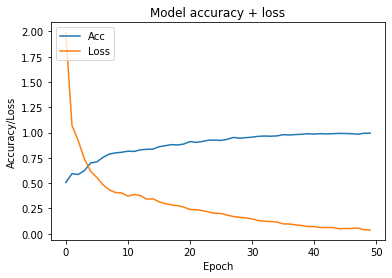

In [36]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
#plt.plot(history.history['val_acc'])
plt.title('Model accuracy + loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(['Acc', 'Loss'], loc='upper left')
plt.show()

# Plot training & validation loss values
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.title('Model loss')
#plt.ylabel('Loss')
#plt.xlabel('Epoch')
#plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()

In [37]:
predictions = model.predict(Xtest_pad)

In [38]:
predictions[:5]

array([[5.9336424e-04],
       [7.7647746e-01],
       [9.9992836e-01],
       [3.5730898e-03],
       [1.0237396e-03]], dtype=float32)

In [39]:
pred_converted = [0 if p < 0.5 else 1 for p in predictions]
pred_converted[:5]

[0, 1, 1, 0, 0]

In [40]:
pred = np.argmax(predictions, axis=1)
#Ytest_converted = np.argmax(Ytest_bin, axis=1)

print(classification_report(Ytest_bin, pred_converted))

              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87       260
         1.0       0.82      0.76      0.79       173

    accuracy                           0.84       433
   macro avg       0.83      0.82      0.83       433
weighted avg       0.84      0.84      0.83       433

